### Installing Required Dependencies

This cell installs all external libraries required for the project to run smoothly in the Google Colab environment. These include packages for transformer-based models, dataset processing, metrics evaluation, and visualization. This step ensures that all necessary tools are available before executing the main pipeline.

In [3]:
# Install required dependencies
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

packages = [
    "openpyxl",
    "langdetect",
    "pandas",
    "numpy",
    "transformers",
    "datasets",
    "evaluate",
    "torch",
    "matplotlib",
    "seaborn",
    "accelerate",
    "plotly"
]

for package in packages:
    try:
        if package == "transformers":
            import transformers
        elif package == "datasets":
            import datasets
        elif package == "evaluate":
            import evaluate
        elif package == "torch":
            import torch
        elif package == "accelerate":
            import accelerate
        elif package == "plotly":
            import plotly
        else:
            __import__(package.replace("-", "_"))
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)

# Import libraries
import pandas as pd
import numpy as np
import os
import re
import glob
import time
import gc
from itertools import product
from langdetect import detect, DetectorFactory
from google.colab import drive
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
DetectorFactory.seed = 0
np.random.seed(42)
torch.manual_seed(42)

# Check for GPU and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Memory management for Colab
def cleanup_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB


### Mounting Google Drive

This cell mounts the user's Google Drive to the current Colab session. All datasets, model checkpoints, and result files are stored and accessed through Google Drive to maintain persistence and avoid data loss between sessions. This step is essential for managing larger files and organizing experimental outputs.

In [4]:
# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Read and Combine Data
print("Loading dataset files...")
data_path = '/content/drive/MyDrive/Thesis/dataset/Indonesia/'
xlsx_files = glob.glob(os.path.join(data_path, '*.xlsx'))

if not xlsx_files:
    print(f"No .xlsx files found in {data_path}")
    print("Please check the path and ensure files exist.")
else:
    print(f"Found {len(xlsx_files)} .xlsx files")

all_reviews = []

def clean_text(text):
    """Clean text by removing HTML, emojis, non-ASCII, and extra spaces"""
    if pd.isna(text):
        return ""

    text = str(text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip().lower()

    return text

def is_english(text):
    """Check if text is predominantly in English"""
    try:
        if len(text.strip()) < 10:
            return False
        return detect(text) == 'en'
    except:
        return False

for file_path in xlsx_files:
    try:
        print(f"Processing {os.path.basename(file_path)}...")
        df = pd.read_excel(file_path)

        if 'Review Title' not in df.columns or 'Review Text' not in df.columns or 'Rating' not in df.columns:
            print(f"Skipping {file_path}: Missing required columns")
            continue

        df['text'] = df['Review Title'].astype(str) + ' ' + df['Review Text'].astype(str)
        df = df.dropna(subset=['text', 'Rating'])
        df = df[df['text'].str.len() > 10]
        df['text'] = df['text'].apply(clean_text)
        df = df[df['text'].str.len() > 5]

        print(f"Filtering for English text...")
        df['is_english'] = df['text'].apply(is_english)
        df = df[df['is_english'] == True]
        df = df.drop('is_english', axis=1)
        df = df[['text', 'Rating']].copy()

        all_reviews.append(df)
        print(f"Added {len(df)} English reviews from {os.path.basename(file_path)}")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

if not all_reviews:
    print("No valid data found. Please check your files.")
else:
    combined_df = pd.concat(all_reviews, ignore_index=True)
    print(f"\nTotal combined reviews: {len(combined_df)}")

# Aspect Labeling
print("\nApplying aspect labeling...")

digital_keywords = [
    'digital', 'wifi', 'internet', 'charging', 'application', 'self check-in',
    'self service', 'qr code', 'technology', 'website', 'touchscreen',
    'cashless', 'online booking', 'digital map', 'barcode', 'scan',
    'mobile app', 'online system', 'connectivity', 'device'
]

service_keywords = [
    'service', 'staff', 'employee', 'security', 'cashier', 'greeting',
    'customer service', 'hospitality', 'slow', 'helpful', 'unhelpful',
    'rude', 'polite', 'friendly', 'unfriendly', 'queue', 'waiting',
    'assistance', 'responsiveness', 'behavior'
]

def assign_aspect(text):
    text_lower = text.lower()
    for keyword in digital_keywords:
        if keyword in text_lower:
            return 'digital_accessibility'
    for keyword in service_keywords:
        if keyword in text_lower:
            return 'customer_service'
    return 'other'

combined_df['aspect'] = combined_df['text'].apply(assign_aspect)

# Sentiment Labeling based on Rating
print("Applying sentiment labeling based on ratings...")

def assign_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

combined_df['sentiment'] = combined_df['Rating'].apply(assign_sentiment)

# Data Filtering
print("\nFiltering data...")
print(f"Before filtering: {len(combined_df)} samples")

combined_df = combined_df[combined_df['aspect'] != 'other']
print(f"After removing 'other' aspect: {len(combined_df)} samples")

combined_df = combined_df[combined_df['sentiment'] != 'neutral']
print(f"After removing 'neutral' sentiment: {len(combined_df)} samples")

print("\nFinal class distribution:")
print("Aspect distribution:")
print(combined_df['aspect'].value_counts())
print("\nSentiment distribution:")
print(combined_df['sentiment'].value_counts())

# Dataset Split and Label Encoding
print("\nSplitting dataset and encoding labels...")

aspect_labels = sorted(combined_df['aspect'].unique())
sentiment_labels = sorted(combined_df['sentiment'].unique())

aspect_label2id = {label: i for i, label in enumerate(aspect_labels)}
aspect_id2label = {i: label for label, i in aspect_label2id.items()}

sentiment_label2id = {label: i for i, label in enumerate(sentiment_labels)}
sentiment_id2label = {i: label for label, i in sentiment_label2id.items()}

print(f"Aspect labels: {aspect_labels}")
print(f"Sentiment labels: {sentiment_labels}")

combined_df['aspect_labels'] = combined_df['aspect'].map(aspect_label2id)
combined_df['sentiment_labels'] = combined_df['sentiment'].map(sentiment_label2id)

# Split data
X = combined_df['text']
y_aspect = combined_df['aspect_labels']
y_sentiment = combined_df['sentiment_labels']

stratify_key = combined_df['aspect'].astype(str) + '_' + combined_df['sentiment'].astype(str)

X_temp, X_test, y_aspect_temp, y_aspect_test, y_sentiment_temp, y_sentiment_test = train_test_split(
    X, y_aspect, y_sentiment, test_size=0.15, random_state=42, stratify=stratify_key
)

# Create temp stratify key
temp_df = pd.DataFrame({
    'text': X_temp,
    'aspect_labels': y_aspect_temp,
    'sentiment_labels': y_sentiment_temp
})
temp_df['aspect'] = temp_df['aspect_labels'].map(aspect_id2label)
temp_df['sentiment'] = temp_df['sentiment_labels'].map(sentiment_id2label)
stratify_temp = temp_df['aspect'].astype(str) + '_' + temp_df['sentiment'].astype(str)

X_train, X_val, y_aspect_train, y_aspect_val, y_sentiment_train, y_sentiment_val = train_test_split(
    X_temp, y_aspect_temp, y_sentiment_temp, test_size=0.176, random_state=42, stratify=stratify_temp
)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Mounting Google Drive...
Mounted at /content/drive
Loading dataset files...
Found 50 .xlsx files
Processing IDN_WEST JAVA_White Crater.xlsx...
Filtering for English text...
Added 928 English reviews from IDN_WEST JAVA_White Crater.xlsx
Processing IDN_WEST JAVA_Taman Safari Indonesia Bogor.xlsx...
Filtering for English text...
Added 766 English reviews from IDN_WEST JAVA_Taman Safari Indonesia Bogor.xlsx
Processing IDN_WEST JAVA_Braga Street.xlsx...
Filtering for English text...
Added 874 English reviews from IDN_WEST JAVA_Braga Street.xlsx
Processing IDN_WEST JAVA_Kebun Raya Bogor.xlsx...
Filtering for English text...
Added 725 English reviews from IDN_WEST JAVA_Kebun Raya Bogor.xlsx
Processing IDN_WEST JAVA_Paris Van Java.xlsx...
Filtering for English text...
Added 706 English reviews from IDN_WEST JAVA_Paris Van Java.xlsx
Processing IDN_WEST JAVA_Rumah Mode Factory Outlet.xlsx...
Filtering for English text...
Added 865 English reviews from IDN_WEST JAVA_Rumah Mode Factory Outlet.xlsx

### Model and Hyperparameter Configuration

This section defines the core configurations for the fine-tuning process. It includes model names, hyperparameters such as learning rate and number of epochs, and other training arguments. Setting these values upfront makes the training process reproducible and easier to manage, especially when experimenting with multiple models.

In [5]:
# Model and Hyperparameter Configuration
print("\nSetting up models and hyperparameters...")

# Models to compare
models_config = {
    'distilbert-base-uncased': {
        'name': 'DistilBERT',
        'model_name': 'distilbert-base-uncased'
    },
    'bert-base-uncased': {
        'name': 'BERT',
        'model_name': 'bert-base-uncased'
    },
    'roberta-base': {
        'name': 'RoBERTa',
        'model_name': 'roberta-base'
    }
}

# Hyperparameters to tune (optimized for free Colab T4 GPU)
hyperparams = {
    'learning_rate': [2e-5, 5e-5],  # Reduced from 3 to 2 options
    'per_device_train_batch_size': [8, 16],  # Keep 2 options
    'num_train_epochs': [2, 3]  # Keep 2 options but reduced max
}

# Generate all combinations
hyperparam_combinations = list(product(
    hyperparams['learning_rate'],
    hyperparams['per_device_train_batch_size'],
    hyperparams['num_train_epochs']
))

print(f"Total hyperparameter combinations per model: {len(hyperparam_combinations)}")
print(f"Total experiments (ASPECT ONLY): {len(models_config) * len(hyperparam_combinations)}")  # Only aspect classification

# Training and Evaluation Functions
def create_datasets(X_train, X_val, X_test, y_train, y_val, y_test, tokenizer, max_length=256):
    """Create tokenized datasets"""
    def tokenize_function(examples):
        return tokenizer(examples['text'], truncation=True, padding=True, max_length=max_length)

    train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'labels': y_train.tolist()})
    val_dataset = Dataset.from_dict({'text': X_val.tolist(), 'labels': y_val.tolist()})
    test_dataset = Dataset.from_dict({'text': X_test.tolist(), 'labels': y_test.tolist()})

    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    return train_dataset, val_dataset, test_dataset


Setting up models and hyperparameters...
Total hyperparameter combinations per model: 8
Total experiments (ASPECT ONLY): 24


### Loading Evaluation Metrics

This cell imports the evaluation functions used to assess the performance of each model. These typically include precision, recall, F1-score, and accuracy. Defining these metrics explicitly allows for consistent evaluation across all models and hyperparameter settings.


In [6]:
# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1']
    }

def train_model(model_name, train_dataset, val_dataset, test_dataset, num_labels,
                id2label, label2id, task_name, lr, batch_size, epochs):
    """Train a single model with given hyperparameters"""

    print(f"Training {model_name} - {task_name} | LR: {lr}, BS: {batch_size}, Epochs: {epochs}")

    # Initialize model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f'./results_{task_name}_{model_name.replace("/", "_")}',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=lr,
        warmup_steps=100,
        weight_decay=0.01,
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        save_total_limit=1,
        report_to=[],
        dataloader_pin_memory=False,
        gradient_accumulation_steps=2 if batch_size == 8 else 1  # Help with small batch sizes
    )

    # Data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Initialize trainer with early stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

    # Train model
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    # Evaluate on test set
    test_results = trainer.evaluate(test_dataset)

    # Get predictions
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids

    # Cleanup
    del model, trainer
    cleanup_memory()

    return {
        'model_name': model_name,
        'task': task_name,
        'learning_rate': lr,
        'batch_size': batch_size,
        'epochs': epochs,
        'test_accuracy': test_results['eval_accuracy'],
        'test_f1': test_results['eval_f1'],
        'training_time': training_time,
        'predictions': y_pred,
        'true_labels': y_true
    }

### Running Hyperparameter Tuning for All Models

This section executes the training and hyperparameter tuning for all candidate models. Each model is fine-tuned on the training set using the configurations defined earlier, and performance is evaluated to select the best-performing setup. This step is computationally intensive and may take a significant amount of time depending on the number of models and hyperparameters tested.


In [7]:
# Run Hyperparameter Tuning for All Models
print("\n" + "="*80)
print("STARTING HYPERPARAMETER TUNING")
print("="*80)

results = []

for model_key, model_info in models_config.items():
    print(f"\n{'='*60}")
    print(f"TRAINING {model_info['name'].upper()} MODELS")
    print(f"{'='*60}")

    model_name = model_info['model_name']

    # Initialize tokenizer for this model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Create datasets for aspect classification only
    aspect_train_ds, aspect_val_ds, aspect_test_ds = create_datasets(
        X_train, X_val, X_test, y_aspect_train, y_aspect_val, y_aspect_test, tokenizer
    )

    # Train with each hyperparameter combination (ASPECT ONLY)
    for lr, batch_size, epochs in hyperparam_combinations:
        try:
            # Train aspect model only
            aspect_result = train_model(
                model_name, aspect_train_ds, aspect_val_ds, aspect_test_ds,
                len(aspect_labels), aspect_id2label, aspect_label2id,
                'aspect', lr, batch_size, epochs
            )
            results.append(aspect_result)

        except Exception as e:
            print(f"Error training {model_name} with LR={lr}, BS={batch_size}, Epochs={epochs}: {e}")
            cleanup_memory()
            continue


STARTING HYPERPARAMETER TUNING

TRAINING DISTILBERT MODELS


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2712 [00:00<?, ? examples/s]

Map:   0%|          | 0/580 [00:00<?, ? examples/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Training distilbert-base-uncased - aspect | LR: 2e-05, BS: 8, Epochs: 2


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.274900,0.227398,0.932759,0.929518
2,0.138900,0.155874,0.963793,0.960495


Training distilbert-base-uncased - aspect | LR: 2e-05, BS: 8, Epochs: 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.268700,0.227516,0.901724,0.855126
2,0.142500,0.145720,0.965517,0.962576
3,0.043100,0.144119,0.968966,0.966319


Training distilbert-base-uncased - aspect | LR: 2e-05, BS: 16, Epochs: 2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.245700,0.201477,0.948276,0.944997
2,0.124500,0.148138,0.965517,0.962576


Training distilbert-base-uncased - aspect | LR: 2e-05, BS: 16, Epochs: 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.279600,0.234777,0.931034,0.928694
2,0.128000,0.133444,0.967241,0.964633
3,0.044100,0.134407,0.972414,0.970370


Training distilbert-base-uncased - aspect | LR: 5e-05, BS: 8, Epochs: 2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.180100,0.148197,0.963793,0.960495
2,0.102000,0.126364,0.970690,0.968356


Training distilbert-base-uncased - aspect | LR: 5e-05, BS: 8, Epochs: 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.187500,0.144825,0.962069,0.959664
2,0.117900,0.092008,0.981034,0.980120
3,0.020200,0.107079,0.977586,0.977125


Training distilbert-base-uncased - aspect | LR: 5e-05, BS: 16, Epochs: 2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.164100,0.138918,0.965517,0.962576
2,0.102800,0.122305,0.970690,0.969277


Training distilbert-base-uncased - aspect | LR: 5e-05, BS: 16, Epochs: 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.162100,0.140277,0.963793,0.961306
2,0.101600,0.122599,0.974138,0.973140
3,0.016300,0.138222,0.975862,0.974816



TRAINING BERT MODELS


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2712 [00:00<?, ? examples/s]

Map:   0%|          | 0/580 [00:00<?, ? examples/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Training bert-base-uncased - aspect | LR: 2e-05, BS: 8, Epochs: 2


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.289300,0.268188,0.903448,0.859290
2,0.133500,0.156429,0.962069,0.959258


Training bert-base-uncased - aspect | LR: 2e-05, BS: 8, Epochs: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.285600,0.241574,0.922414,0.919420
2,0.129000,0.145781,0.963793,0.961685
3,0.042600,0.166237,0.968966,0.966998


Training bert-base-uncased - aspect | LR: 2e-05, BS: 16, Epochs: 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.261800,0.217092,0.920690,0.921882
2,0.122000,0.149764,0.965517,0.963331


Training bert-base-uncased - aspect | LR: 2e-05, BS: 16, Epochs: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.281600,0.304546,0.932759,0.929518
2,0.112800,0.139483,0.968966,0.967316
3,0.040100,0.156067,0.970690,0.968983


Training bert-base-uncased - aspect | LR: 5e-05, BS: 8, Epochs: 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.197300,0.137195,0.962069,0.959258
2,0.088900,0.123746,0.977586,0.976721


Training bert-base-uncased - aspect | LR: 5e-05, BS: 8, Epochs: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.204600,0.146167,0.962069,0.958390
2,0.128400,0.090511,0.981034,0.980120
3,0.024600,0.119572,0.977586,0.976928


Training bert-base-uncased - aspect | LR: 5e-05, BS: 16, Epochs: 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.185300,0.172402,0.955172,0.951851
2,0.106600,0.150526,0.967241,0.964991


Training bert-base-uncased - aspect | LR: 5e-05, BS: 16, Epochs: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.234200,0.129031,0.963793,0.960910
2,0.091500,0.073578,0.984483,0.983884
3,0.026200,0.105791,0.982759,0.982011



TRAINING ROBERTA MODELS


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/2712 [00:00<?, ? examples/s]

Map:   0%|          | 0/580 [00:00<?, ? examples/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Training roberta-base - aspect | LR: 2e-05, BS: 8, Epochs: 2


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.306600,0.341694,0.901724,0.855126
2,0.182100,0.180506,0.956897,0.954387


Training roberta-base - aspect | LR: 2e-05, BS: 8, Epochs: 3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.306300,0.380058,0.901724,0.855126
2,0.176000,0.189572,0.958621,0.956827
3,0.069300,0.169451,0.965517,0.962172


Training roberta-base - aspect | LR: 2e-05, BS: 16, Epochs: 2


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.310500,0.319375,0.901724,0.855126
2,0.245600,0.236312,0.912069,0.904060


Training roberta-base - aspect | LR: 2e-05, BS: 16, Epochs: 3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.296100,0.289370,0.901724,0.855126
2,0.175200,0.154713,0.963793,0.960495
3,0.051600,0.173056,0.967241,0.964258


Training roberta-base - aspect | LR: 5e-05, BS: 8, Epochs: 2


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.314200,0.323550,0.901724,0.855126
2,0.214400,0.186605,0.958621,0.955554


Training roberta-base - aspect | LR: 5e-05, BS: 8, Epochs: 3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.308800,0.312503,0.901724,0.855126
2,0.159200,0.180921,0.963793,0.961306
3,0.047400,0.167155,0.967241,0.964258


Training roberta-base - aspect | LR: 5e-05, BS: 16, Epochs: 2


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.312500,0.324134,0.901724,0.855126
2,0.270300,0.242758,0.922414,0.915347


Training roberta-base - aspect | LR: 5e-05, BS: 16, Epochs: 3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.327700,0.360262,0.901724,0.855126
2,0.314500,0.324498,0.901724,0.855126


### Result Analysis and Visualization

After training is complete, this cell analyzes the evaluation results for each model. It may include visual comparisons such as bar plots or line charts for F1-scores, confusion matrices, or training loss curves. The goal is to interpret which model performs best under the defined criteria and justify its selection.



ANALYZING RESULTS
Total completed experiments: 24

Best Results by Model and Task:
BERT - Aspect: F1=0.9766, Acc=0.9777 | LR=5e-05, BS=8, E=2
DistilBERT - Aspect: F1=0.9783, Acc=0.9794 | LR=5e-05, BS=16, E=3
RoBERTa - Aspect: F1=0.9603, Acc=0.9639 | LR=5e-05, BS=8, E=3

Creating visualizations...



Creating hyperparameter analysis...


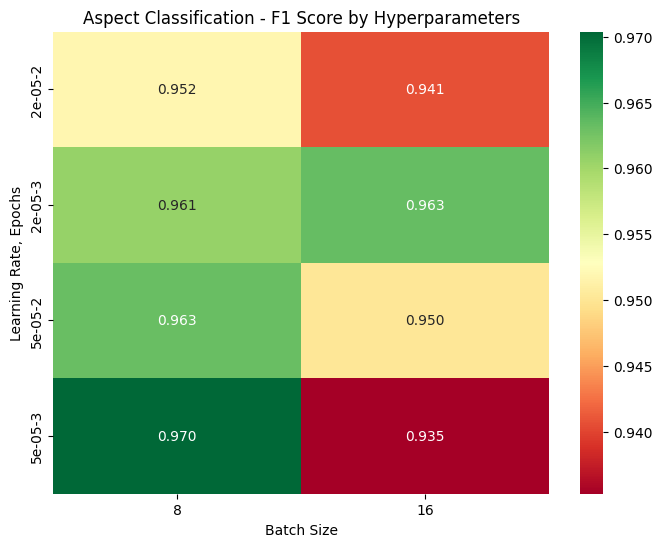


FINAL RESULTS SUMMARY
     Model   Task Accuracy F1-Score  Learning Rate  Batch Size  Epochs Training Time (s)
      BERT Aspect   0.9777   0.9766        0.00005           8       2             291.3
DistilBERT Aspect   0.9794   0.9783        0.00005          16       3             209.8
   RoBERTa Aspect   0.9639   0.9603        0.00005           8       3             462.4


In [8]:
# Results Analysis and Visualization
print("\n" + "="*80)
print("ANALYZING RESULTS")
print("="*80)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(f"Total completed experiments: {len(results_df)}")

# Best results for each model-task combination
print("\nBest Results by Model and Task:")
best_results = results_df.loc[results_df.groupby(['model_name', 'task'])['test_f1'].idxmax()]

for _, row in best_results.iterrows():
    model_display = models_config.get(row['model_name'], {}).get('name', row['model_name'])
    print(f"{model_display} - {row['task'].title()}: F1={row['test_f1']:.4f}, "
          f"Acc={row['test_accuracy']:.4f} | LR={row['learning_rate']}, BS={row['batch_size']}, E={row['epochs']}")

# Comprehensive Visualizations
print("\nCreating visualizations...")

# Performance comparison plots - ASPECT ONLY
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Aspect Classification - Accuracy', 'Aspect Classification - F1 Score'],
    horizontal_spacing=0.15
)

# Only aspect results
aspect_results = results_df[results_df['task'] == 'aspect']

# Group by model for box plots
for metric_idx, metric in enumerate(['test_accuracy', 'test_f1']):
    col = metric_idx + 1

    for model_name in aspect_results['model_name'].unique():
        model_data = aspect_results[aspect_results['model_name'] == model_name]
        model_display = models_config.get(model_name, {}).get('name', model_name)

        fig.add_trace(
            go.Box(y=model_data[metric], name=model_display,
                  boxpoints='all', jitter=0.3, pointpos=-1.8),
            row=1, col=col
        )

fig.update_layout(height=400, title_text="Aspect Classification: Model Performance Comparison")
fig.show()

# Best hyperparameters heatmap
print("\nCreating hyperparameter analysis...")

# Performance by hyperparameters
hyperparam_analysis = results_df.groupby(['task', 'learning_rate', 'batch_size', 'epochs']).agg({
    'test_f1': 'mean',
    'test_accuracy': 'mean',
    'training_time': 'mean'
}).reset_index()

# Create heatmap for aspect classification only
task_data = hyperparam_analysis[hyperparam_analysis['task'] == 'aspect']

# Pivot for heatmap
heatmap_data = task_data.pivot_table(
    values='test_f1',
    index=['learning_rate', 'epochs'],
    columns='batch_size',
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn')
plt.title('Aspect Classification - F1 Score by Hyperparameters')
plt.xlabel('Batch Size')
plt.ylabel('Learning Rate, Epochs')
plt.show()

# Detailed Results Table
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

# Create comprehensive results table
summary_table = []
for _, row in best_results.iterrows():
    model_display = models_config.get(row['model_name'], {}).get('name', row['model_name'])

    # Get confusion matrix for best model
    if row['task'] == 'aspect':
        target_names = [aspect_id2label[i] for i in range(len(aspect_labels))]
    else:
        target_names = [sentiment_id2label[i] for i in range(len(sentiment_labels))]

    summary_table.append({
        'Model': model_display,
        'Task': row['task'].title(),
        'Accuracy': f"{row['test_accuracy']:.4f}",
        'F1-Score': f"{row['test_f1']:.4f}",
        'Learning Rate': row['learning_rate'],
        'Batch Size': int(row['batch_size']),
        'Epochs': int(row['epochs']),
        'Training Time (s)': f"{row['training_time']:.1f}"
    })

summary_df = pd.DataFrame(summary_table)
print(summary_df.to_string(index=False))

### Confusion Matrices for Best Models (Aspect Prediction Only)

This final analysis cell focuses on generating and displaying confusion matrices for the best-performing models, specifically on the aspect classification task. Confusion matrices provide a granular view of model predictions, highlighting which aspect classes are frequently confused and where the model excels or struggles.



Confusion Matrices for Best Aspect Models:


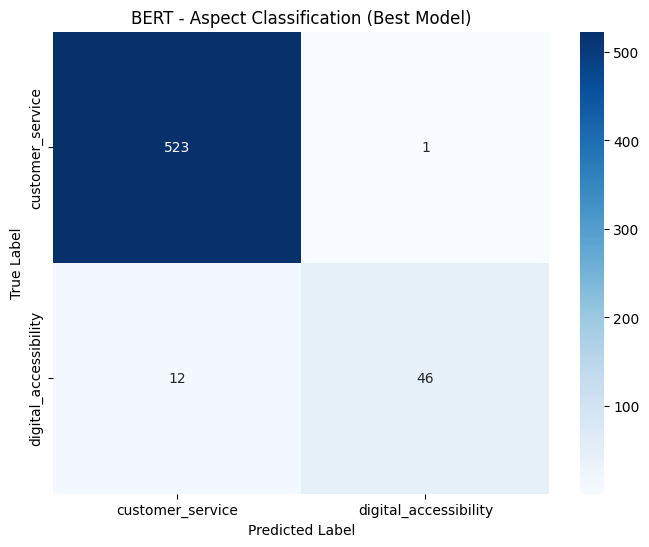


BERT - Aspect Classification Report:
                       precision    recall  f1-score   support

     customer_service       0.98      1.00      0.99       524
digital_accessibility       0.98      0.79      0.88        58

             accuracy                           0.98       582
            macro avg       0.98      0.90      0.93       582
         weighted avg       0.98      0.98      0.98       582



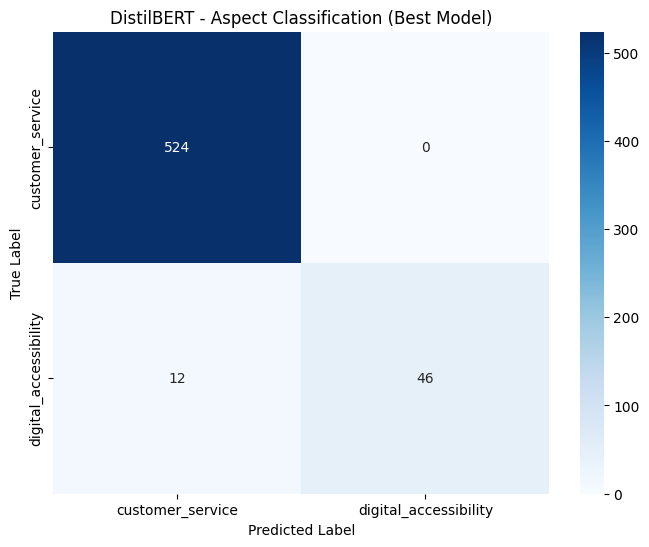


DistilBERT - Aspect Classification Report:
                       precision    recall  f1-score   support

     customer_service       0.98      1.00      0.99       524
digital_accessibility       1.00      0.79      0.88        58

             accuracy                           0.98       582
            macro avg       0.99      0.90      0.94       582
         weighted avg       0.98      0.98      0.98       582



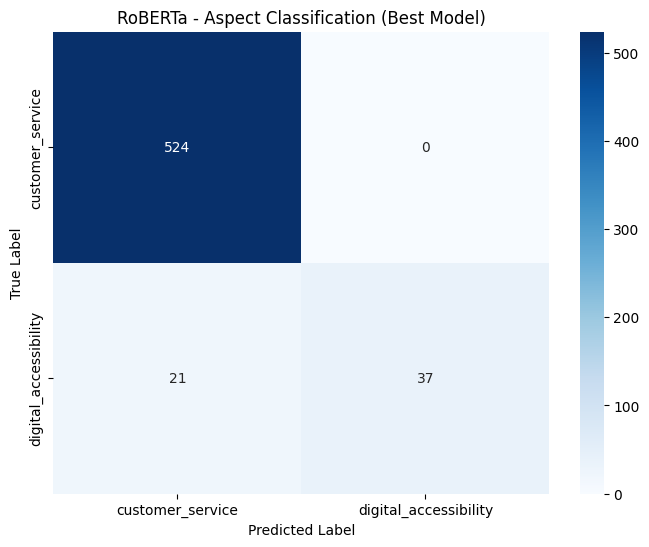


RoBERTa - Aspect Classification Report:
                       precision    recall  f1-score   support

     customer_service       0.96      1.00      0.98       524
digital_accessibility       1.00      0.64      0.78        58

             accuracy                           0.96       582
            macro avg       0.98      0.82      0.88       582
         weighted avg       0.97      0.96      0.96       582


ASPECT CLASSIFICATION HYPERPARAMETER TUNING COMPLETED!


In [9]:
# Confusion Matrices for Best Models (Aspect Only)
print("\nConfusion Matrices for Best Aspect Models:")

for _, row in best_results.iterrows():
    model_display = models_config.get(row['model_name'], {}).get('name', row['model_name'])
    target_names = [aspect_id2label[i] for i in range(len(aspect_labels))]

    cm = confusion_matrix(row['true_labels'], row['predictions'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'{model_display} - Aspect Classification (Best Model)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report
    print(f"\n{model_display} - Aspect Classification Report:")
    print(classification_report(row['true_labels'], row['predictions'],
                              target_names=target_names))

print("\n" + "="*80)
print("ASPECT CLASSIFICATION HYPERPARAMETER TUNING COMPLETED!")
print("="*80)

# Final cleanup
cleanup_memory()